## Clasificador de Basura con uso de Inteligencia Artificial

El siguiente proceso, describe la metodología llevada a cabo para la realización de un modelo de IA, clasificador de imagenes, por categoría.

En este caso, hay 9 categorías o mejor dicho 9 clases (hablando en términos de IA).

Un modelo clasificatorio es un modelo de Inteligencia Artificial, dentro de la rama de entrenamiento supervisado.

Un problema que nos habla acerca de clasificaciones, quiere decir que, por medio del correcto etiquetado de los datos, se puede llegar a la predicción de la pertenencia a una categoría dada una entrada de por medio.

Un modelo de IA clasificatorio supervisado, debe ser entrenado con CNN (Convolutional Neural Networks).
[PONER EXPLICACION DE PORQUE CNNs]

Las clasificaciones del modelo son:
* Vegetación
* Basura de textil
* Plástico
* Papel
* Basura miscelánea
* Metal
* Vidrio
* Comida Orgánica
* Cartón

#### Metodología
1. Recolección de datos (dataset) en: [https://archive.ics.uci.edu/dataset/908/realwaste]
2. Verificación y validación de (dataset) de manera local
3. Recolección de datos (dataset) en: [https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification?resource=download] y [https://www.kaggle.com/datasets/alexanderuzhinskiy/moss-species-classification-dataset]
4. Uso de scripts en shell para organización de imagenes por categorías ({clase}_{i}.jpg)
5. Merge y separación de datos en batch de manera local
6. Data splitting 70% training, 15% validation y 15% testing (se aplicó shuffle disminuyendo el bias por ciertas imágenes)
7. Pre-procesado de datos (Siguiendo ideas de procesos de papers, ver sección abajo Ruido Gaussiano, Detección de border con Canny, étc)
8. Data augmentation (balanceo de clases en disco)
9. Data splitting, a nuevo directorio
10. Feature engineering (feature extraction) con modelo pre-entrenado VGG16
11. Construcción y entrenamiento del modelo con arquitectura CNN
12. Muestra de gráficas (entrenamiento vs precisión de validación y entrenamiento vs pérdida de validación)
13. Iteración del paso 11 en adelante

### Selección de datos

In [ ]:
%pip install tensorflow
%pip install pydot
%pip install opencv-python

In [1]:
# Split the data into training and testing sets
# 70% for training and 15% for testing and 15% for validation
import os, shutil, pathlib
from pathlib import Path
import random

original_dir: Path = pathlib.Path.cwd()
new_base_dir: Path = pathlib.Path.cwd() / 'trash_classifier'

CATEGORIES: list[str] = ['Vegetation', 'Textile Trash', 'Plastic',\
                        'Paper', 'Miscellaneous Trash', 'Metal', 'Glass',\
                        'Food Organics', 'Cardboard'
                        ]

def get_length_of_category(path: Path) -> int:
  '''Get the number of files in a category directory.
  Args:
      path (Path): Path to the category directory.
  Returns:
      int: Number of files in the category directory.
  '''
  return len([f for f in path.iterdir() if f.is_file() and f.suffix == '.jpg'])

def get_all_catefory_files(path: Path) -> list[str]:
  '''Get all files in a category directory sorted by name.
  Args:
      path (Path): Path to the category directory.
  Returns:
      list[str]: List of file names in the category directory.
  '''
  return sorted([f.name for f in path.iterdir() if f.is_file() and f.suffix == '.jpg'])

def split_dataset(filenames: list[str], split_ratios: tuple[float, float, float]) -> tuple[
                                                                  list[str], list[str], list[str]
                                                              ]:
  '''Split the dataset into training, testing, and validation sets.
  Args:
      filenames (list[str]): List of file names to split.
      split_ratios (tuple[float, float, float]): Split ratios for training, testing, and validation sets.
  Returns:
      tuple[list[str], list[str], list[str]]: Tuple of lists containing training, testing, and validation file names.
  '''
  assert abs(sum(split_ratios)-1.0) < 1e-6, "Split ratios must sum to 1"
  random.shuffle(filenames)
  total = len(filenames)
  train_end = int(split_ratios[0] * total)
  test_end = int(train_end + (split_ratios[1] * total))
  return filenames[:train_end], filenames[train_end:test_end], filenames[test_end:]

def copy_files(src_dir: Path, dst_dir: Path, filenames: list[str], subset_name: str, category: str) -> None:
  '''Copy files from source directory to destination directory.
  Args:
      src_dir (Path): Source directory containing the files.
      dst_dir (Path): Destination directory to copy the files to.
      filenames (list[str]): List of file names to copy.
      subset_name (str): Name of the subset (train, test, val).
      category (str): Category of the files.
  Returns:
      None
  '''
  dst_dir = dst_dir / subset_name / category
  try:
      os.makedirs(dst_dir)
  except OSError:
      raise OSError(f"Directory {dst_dir} already exists.")
  for filename in filenames:
    shutil.copyfile(src=src_dir / category / filename, dst=dst_dir / filename)
        
def prepare_subsets(base_dir: Path, target_dir: Path) -> None:
  '''Prepare the subsets of the dataset by splitting and copying files.
  Args:
      base_dir (Path): Base directory containing the original dataset.
      target_dir (Path): Target directory to copy the subsets to.
  Returns:
    None
  '''
  for category in CATEGORIES:
    all_files = get_all_catefory_files(base_dir / category)
    train_files, test_files, val_files = split_dataset(all_files, (0.7, 0.15, 0.15))
    copy_files(base_dir, target_dir, train_files, 'train', category)
    copy_files(base_dir, target_dir, test_files, 'test', category)
    copy_files(base_dir, target_dir, val_files, 'val', category)


### Data splitting before pre-processing

In [3]:
prepare_subsets(original_dir, new_base_dir)
# Check the number of files in each category
for category in CATEGORIES:
  train_count = get_length_of_category(new_base_dir / 'train' / category)
  test_count = get_length_of_category(new_base_dir / 'test' / category)
  val_count = get_length_of_category(new_base_dir / 'val' / category)
  print(f"{category}: Train: {train_count}, Test: {test_count}, Val: {val_count}")


Vegetation: Train: 685, Test: 146, Val: 148
Textile Trash: Train: 528, Test: 113, Val: 114
Plastic: Train: 982, Test: 210, Val: 211
Paper: Train: 765, Test: 164, Val: 165
Miscellaneous Trash: Train: 375, Test: 80, Val: 81
Metal: Train: 840, Test: 180, Val: 180
Glass: Train: 644, Test: 138, Val: 139
Food Organics: Train: 637, Test: 136, Val: 138
Cardboard: Train: 604, Test: 129, Val: 131


## Data pre-processing

Se ha investigado arduamente en varios papers la mejor forma de detección de objetos, para su mejor reconocimiento.
Entre las investigaciones, se ha encontrado la siguiente información importante, así como las técnicas de entrenamiento pertinentes.

### Tipos de ruido [2]:
* Ruido amplificador (Ruido Gaussiano)
  * Forma idealizada del ruido blanco causado por fluctuaciones de señal. Puede haber más ruido en el canal azul que en el rojo y verde. 
* Ruido de impulsivo (Ruido de sal y pimienta)
  * Cuando hay "puntos" que pueden ser "pixeles muertos" encontrados en la imagen.
* Ruido de tiro
  * Sigue distribución Poisson, no tan diferente a la Gaussiana. Se identifica cuando el ruido es causado por los puntos con mayor luz "photon shot noise" y en áreas oscuras "dark shot noise" o "dark-current shot noise".
* Ruido de cuantización (ruido uniforme)
  * Causado al cuanitificar los pixelexs de una imagen percibida hacia un número discreto de niveles.
* Film grain
  * El grano de una "película" fotográfica es una señal de ruido dependiente, relacionada con el ruido de tiro. 
* Ruido on-isotropico
* Ruido de mancha (Ruido Multiplicativo)
  * Ruido granular, que inherentemente existe dentro y degrada la calidad del radar activo y la apertura sintética de las de imágenes (SAR). Puede ser modelado con valores aleatorios multiplicados por cada valor de pixel, por eso el nombre. 
* Ruido periódico

### Realce de contraste [2]
Mejoramiento de la calidad de una imagen por medio de la equivalencia de histogramas. No se borran los detalles importantes. Incrementan la identificación del punto clave dentro de la imagen, mejorando la modificación de la imagen.
Existen ADE, CLAHE y AHE.
Con CLAHE, la imagen de entrada original es dividida en contextos de componentes no sobre-puestos llamados "sub-imágenes", celdas, o bloques utilizando el procedimiento CLAHE. Los dos parámetros de CLAHE que regulan la calidad de la imagen son bloques con tamaño y limitan el recorte. El histograma original es recortado, y se los pixeles recortados son redistribuidos en un nivel gris. La intensidad de cada pixel en la re-distribución del histograma está restricto a un máximo específico, no como el histograma estándar. El nivel de fuerza de los valores del pixel en la región del contexto del histograma es el pixel de salida con valor CLAHE. El histograma verdadero es dispersado hacia todas las intenisdades dentro del rango registrado de la iagen, cuando el histograma se concentra en los pixeles recortados en una altura en específico.[1]

### Segmentación [2]
Tarea de suma importancia para un problema de visión de computación, que consiste en particionar la imagen en múltiples segmentos o regiones basadas en ciertas características como su color, intensidad, textura o moción.
La meta de la segmentación es simplificar la representación de la imagen al agrupar los pixeles y regiones que comparten propiedades similares, haciendo más eficiente y sencillo la extracción de "features" de una imagen (datos importantes
de una imagen). Al aplicar esta técnica, se conseguirán regiones segmentadas que habilitan la eficiencia en el análisis e interpretación de los datos de una imagen. Puntos que pueden ser la iluminación de la imagen, en veces llamado bordes
de la imagen. Técnica ampliamente utilizada para procesado de imagenes digitales, modelo de reconocimiento, morfología de imágenes, extracción de recursos. [1]

---

Algorithm to get the basic area of the image, it is also necessary to carry out image grayscale, histogram equalization, image filtering, size normalization. [4]

---
Proceso descrito de detección de objetos, con fines de cortar el objeto importante de una imagen [3]:
1. Aplicación de Ruido Gausiano
2. Aplicación de binarización de imagen
3. Posicionamiento y selección
4. Corte de imagen

---
### Referencias
* [1] A. Demelash and E. Derb, “Habesha Cultural Cloth Classification Using Deep Learning,” Scientific Reports, vol. 15, no. 1, Apr. 2025, doi: https://doi.org/10.1038/s41598-025-98269-5.
* [2] A. Hambal, Z. Pei, and F. Libent, “Image Noise Reduction and Filtering Techniques,” International Journal of Science and Research (IJSR) ISSN, vol. 6, no. 3, pp. 2319–7064, Mar. 2017, doi: https://doi.org/10.21275/25031706.he
* [3] H. Wang, “Garbage Recognition and Classification System Based on Convolutional Neural Network VGG16,” 2020 3rd International Conference on Advanced Electronic Materials, Computers and Software Engineering (AEMCSE), Apr. 2020, doi: https://doi.org/10.1109/aemcse50948.2020.00061. (IMAGE PRE-PROCESSING, OpenCV to crop objects)
* [4] B. Gan and C. Zhang, “Research on the algorithm of urban waste classification and recycling based on deep learning technology,” Research on the algorithm of urban waste classification and recycling based on deep learning technology, Jul. 2020, doi: https://doi.org/10.1109/cvidl51233.2020.00-95.




In [5]:
import cv2
import numpy as np
from typing import Callable

new_base_dir_pre_processed: Path = pathlib.Path.cwd() / 'trash_classifier_pre_processed'

# Process the method from references of papers [1][3]
class ImagePreprocessor:
  '''
  Class to preprocess images for object detection.
  Attributes:
      kernel_size (tuple[int, int]): Size of the kernel for Gaussian blur and morphological operations.
      canny_thresh (tuple[int, int]): Thresholds for Canny edge detection.
      itr (int): Number of iterations for morphological operations.
  '''
  def __init__(self, kernel_size: tuple[int, int] = (5, 5), canny_thresh: tuple[int, int]=(100,200), itr: int = 2) -> None:
    self.kernel_size: tuple[int, int] = kernel_size
    self.canny_thresh: tuple[int, int] = canny_thresh
    self.itr: int = itr 

  # 1. Convert to grayscale all images
  def convert_to_grayscale(self, image: cv2.Mat) -> cv2.Mat:
    '''Convert the image to grayscale.
    Args:
        image (cv2.Mat): Input image.
    Returns:
        cv2.Mat: Grayscale image.
    '''
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # 2. Use Gaussian blur to reduce noise and detail in the image (default kernel size is 5x5) [1]
  def gaussian_blur(self, image: cv2.Mat) -> cv2.Mat:
    '''Apply Gaussian blur to the image.
    Args:
        image (cv2.Mat): Input image.
    Returns:
        cv2.Mat: Gaussian blurred image.
    '''
    return cv2.GaussianBlur(image, self.kernel_size, 0)

  # 3. Use Canny edge detection to detect edges in the image
  def canny_edge_detection(self, image: cv2.Mat) -> cv2.Mat:
    '''Apply Canny edge detection to the image.
    Args:
        image (cv2.Mat): Input image.
        Returns:
        cv2.Mat: Canny edge detected image.
    '''
    return cv2.Canny(image, self.canny_thresh[0], self.canny_thresh[1])

  # 4. Use dilation to increase the size of the edges
  def dilate(self, image: cv2.Mat, kernel: cv2.Mat) -> cv2.Mat:
    '''Apply dilation to the image.
    Args:
        image (cv2.Mat): Input image.
        kernel (cv2.Mat): Structuring element for dilation.
    Returns:
        cv2.Mat: Dilated image.
    '''
    return cv2.dilate(image, kernel, iterations=self.itr)

  # 5. Use erosion to decrease the size of the edges
  def erode(self, image: cv2.Mat, kernel: cv2.Mat) -> cv2.Mat:
    '''Apply erosion to the image.
    Args:
        image (cv2.Mat): Input image.
        kernel (cv2.Mat): Structuring element for erosion.
    Returns:
        cv2.Mat: Eroded image.
    '''
    return cv2.erode(image, kernel, iterations=self.itr)

  # 6. Use countours to find the edges in the image (binary image)
  def find_contours(self, image: cv2.Mat) -> tuple[list[int, int]]:
    '''Find contours in the image.
    Args:
        image (cv2.Mat): Input image.
    Returns:
        tuple[list[int, int]]: List of contours found in the image.
    '''
    countours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return countours

  # 7. Process the image sequentially
  def process(self, image: cv2.Mat) -> np.ndarray:
    '''Process the image using the defined methods.
    Args:
        image (cv2.Mat): Input image.
    Returns:
        np.ndarray: Processed image.
    '''
    grayscale_image: cv2.Mat = self.convert_to_grayscale(image)
    blurred_image: cv2.Mat = self.gaussian_blur(grayscale_image)
    edges: cv2.Mat = self.canny_edge_detection(blurred_image)
    kernel: cv2.Mat = cv2.getStructuringElement(cv2.MORPH_RECT, self.kernel_size)
    dilated_image: cv2.Mat = self.dilate(edges, kernel)
    eroded_image: cv2.Mat = self.erode(dilated_image, kernel)
    contours: list[tuple[int, int]] = self.find_contours(eroded_image)
    if not contours:
      return image
    largest_contour: tuple[int, int] = max(contours, key=cv2.contourArea)
    # Crop the image to the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    highlighted_image: cv2.Mat = image.copy()
    # Draw a rectangle around the largest contour
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # Crop the image to the bounding box of the largest contour
    # Resize the cropped image to a fixed size
    resized_image: cv2.Mat = cv2.resize(highlighted_image, (224, 224))
    # Convert the resized image to a numpy array
    image_array: np.ndarray = np.array(resized_image)
    
    return image_array
  
PreprocessFunc = Callable[[cv2.Mat, ImagePreprocessor], np.ndarray]
WrappedFunc = Callable[[list[str], ImagePreprocessor, str], None]

# Wrapper to apply the function of processing the image from a not processed image
# Apply the preprocessor to the image
# Write the processed image to the output directory
def apply_preprocessing(func: PreprocessFunc) -> WrappedFunc:
  '''Decorator to apply preprocessing to a batch of image paths using a single-image function.
  Args:
      func (PreprocessFunc): Function to be decorated.
  Returns:
      wrapper (WrappedFunc): Decorated function.
  '''
  def wrapper(image_paths: list[str], preprocessor: ImagePreprocessor, output_dir: str) -> None:
    '''Wrapper function to apply preprocessing to images.
    Args:
        image_paths (list[str]): List of image paths to process.
        preprocessor (ImagePreprocessor): Preprocessor instance.
        output_dir (str): Output directory to save processed images.
    Returns:
        None
    '''
    for image_path in image_paths:
      image: cv2.Mat = cv2.imread(image_path)
      # Apply the preprocessor to the image
      if image is None:
        print(f"Error reading image {image_path}")
        continue
      # Process the image using callback function from the decorator
      processed_image: np.ndarray = func(image, preprocessor)
      # Save the processed image
      filename: Path = Path(image_path).name
      output_path: Path = Path(output_dir) / filename
      cv2.imwrite(str(output_path), processed_image)
  return wrapper

# 7. Instantiate the preprocessor
preprocessor: ImagePreprocessor = ImagePreprocessor()

# 8. Apply wrapper to the function as callable
@apply_preprocessing
def pre_process_images(image: cv2.Mat, preprocessor: ImagePreprocessor) -> np.ndarray:
  '''Preprocess the image using the preprocessor.
  Args:
      image (cv2.Mat): Input image.
      preprocessor (ImagePreprocessor): Preprocessor instance.
  Returns:
      np.ndarray: Processed image.
  '''
  return preprocessor.process(image)

# 9. Apply the preprocessor to the images in the dataset
def process_images_in_directory(input_dir: str, output_dir: str) -> None:
  '''
  Process images in the input directory and save them to the output directory.
  Args:
      input_dir (str): Input directory containing images.
      output_dir (str): Output directory to save processed images.
  Returns:
    None
  '''
  # Look for all images ".jpg" in the input directory
  image_paths: list[str] = [str(p) for p in pathlib.Path(input_dir).rglob('*.jpg')]
  # Apply the wrapper function to process the images
  pre_process_images(image_paths, preprocessor, output_dir)

# 10. Process the images in the dataset
def process_dataset(input_dir: str, output_dir: str, label: str) -> None:
  '''
  Process the dataset by applying preprocessing to images in each category.
  Args:
      input_dir (str): Input directory containing the dataset.
      output_dir (str): Output directory to save processed images.
      label (str): Label for the dataset.
  Returns:
      None
  '''
  for category in CATEGORIES:
    # Create the output directory if it doesn't exist
    try:
      os.makedirs(output_dir / label / category)
    except OSError:
      raise OSError(f"Directory {output_dir / label / category} already exists.")
    # Process the images in the input directory
    input_category_dir: Path = input_dir / label / category
    print(f"Processing {category} images from {input_category_dir}")
    output_category_dir: Path = output_dir / label / category
    # Call the main processing function
    process_images_in_directory(input_category_dir, output_category_dir)
    print(f"Processed {category} images from {input_category_dir} to {output_category_dir}")


## Data augmentation

In [6]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from pathlib import Path
# 1. Create a ImageDataGenerator object
datagen: ImageDataGenerator  = ImageDataGenerator(
  rescale=1./255,
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

# 2. For label: train
# 3. Get the greater index regex: "category_{num}.jpg" found in the directory
def get_max_idx(path: Path) -> int:
  '''Get the maximum index of the images in the directory.
  Args:
      path (Path): Path to the directory.
  Returns:
      int: Maximum index of the images in the directory.
  '''
  max_index: int = 0
  for file in path.iterdir():
    if file.is_file() and file.suffix == '.jpg':
      filename: str = file.name
      index: int = int(filename.split('_')[1].split('.')[0])
      max_index = max(max_index, index)
  return max_index

# 4. For each category, augment the images on disk (writting the output image with name "category_{num+1}.jpg" to the same directory of reading)
def process_data_augment_disk():
  '''Process data augmentation on disk for each category.
  Args:
      None
  Returns:
      None
  '''
  for category in CATEGORIES:
    # Get the path to the directory
    input_dir: Path = new_base_dir_pre_processed / 'train' / category
    output_dir: Path = new_base_dir_pre_processed / 'train' / category
    # Get the maximum index of the images in the directory
    max_index: int = get_max_idx(input_dir)
    # Get the images in the directory
    images: list[Path] = [f for f in input_dir.iterdir() if f.is_file() and f.suffix == '.jpg']
    
    # Grab randomly half of the images and augment them
    # n + (num_augmeted * k) >= max_images
    # num_augmented = ceil((max_images - n) / k)
    if len(images) < 1000:
      # Get the number of images to augment
      num_images: int = int(np.ceil((1000 - len(images)) / 5))
      # Get the images to augment
      images: list[Path] = np.random.choice(images, size=num_images, replace=False)
      # Generate the augmented images with the datagen
      for image_path in images:
        img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        x = keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        gen = datagen.flow(x, batch_size=1, save_prefix=category, save_format='jpg')
        # Generate the augmented images
        for _ in range(5):
          next(gen)
          # Save the augmented images
          # Increment the index
          max_index += 1
          # Get the name of the image
          filename: str = f"{category}_{max_index}.jpg"
          # Save the image
          keras.preprocessing.image.save_img(str(output_dir / filename), x[0])
          print(f"Saved {filename} to {output_dir}")


## Data splitting
La siguiente casilla de código fue escrita con fines de hacer el split de la información (no correr, ya está ordenado el dataset)

In [ ]:
# 11. Create the new dataset pre-processed
process_dataset(new_base_dir, new_base_dir_pre_processed, 'test')
process_dataset(new_base_dir, new_base_dir_pre_processed, 'train')
process_dataset(new_base_dir, new_base_dir_pre_processed, 'val')


In [ ]:
process_data_augment_disk()

In [19]:
# Get the number of images in each category
for category in CATEGORIES:
  train_count = get_length_of_category(new_base_dir_pre_processed / 'train' / category)
  test_count = get_length_of_category(new_base_dir_pre_processed / 'test' / category)
  val_count = get_length_of_category(new_base_dir_pre_processed / 'val' / category)
  print(f"{category}: Train: {train_count}, Test: {test_count}, Val: {val_count}")

Vegetation: Train: 1000, Test: 146, Val: 148
Textile Trash: Train: 1003, Test: 113, Val: 114
Plastic: Train: 1002, Test: 210, Val: 211
Paper: Train: 1000, Test: 164, Val: 165
Miscellaneous Trash: Train: 1000, Test: 80, Val: 81
Metal: Train: 1000, Test: 180, Val: 180
Glass: Train: 1004, Test: 138, Val: 139
Food Organics: Train: 1002, Test: 136, Val: 138
Cardboard: Train: 1004, Test: 129, Val: 131


## Training

Problemas con entrenamiento de datos con tamaño batch, la precisión de validación es menor.

To attack the problem with batch :

*Linearly increasing the learning rate with the batch size*

Works empirically for ResNet-50 training. [1]
Choose 0.1 as the initial learning rate for batch size 256, then when changing to a larger batch size b, we will increase the initial learning rate to 0.1 × b/256 [3]


*No decaimiento de bias*

En esta metodología, es aplicado este método. Como en algunos problemas de regularización, se suele utilizar la técnica de regularización L2 a todos los parámetros para que puedan llegar/acercarse a 0. Se recomienda aplicarlo únicamente a los pesos para evitar "overfitting". Solo se aplican a los pesos en capas convolucionales y totalemente conectadas. [1] [2]

*Uso de batches más grandes*

Se genera un decaimiento en la precisión del entrenamiento. [1]


Referencias

[1] F. Chollet, «Deep Learning with Python, Second Edition», O’Reilly Online Learning. https://learning.oreilly.com/library/view/deep-learning-with/9781617296864/Text/08.htm#heading_id_10

[2] P. Goyal, P. Dollar, R. B. Girshick, P. Noordhuis, L. Wesolowski, A. Kyrola, A. Tulloch, Y. Jia, and K. He. Accurate, large minibatch SGD: training imagenet in 1 hour.
CoRR, abs/1706.02677, 2017.

In [20]:
import tensorflow as tf
import keras

curr_dir: Path = pathlib.Path.cwd()

def get_size_directory(path: Path) -> int:
  '''Get the size of the directory.
  Args:
      path (Path): Path to the directory.
  Returns:
      int: Size of the directory.'''
  return len([f for f in path.iterdir() if f.is_file() and f.suffix == '.jpg'])

def dataset_categories(base_dir: str) -> tf.data.Dataset:
  '''Get the dataset from the directory.
  Args:
      base_dir (str): Base directory containing the dataset.
  Returns:
      tf.data.Dataset: Dataset object containing the images and labels.
  '''
  dataset: tf.data.Dataset = keras.utils.image_dataset_from_directory(
    str(curr_dir / 'trash_classifier_pre_processed' / base_dir),
    labels='inferred',
    image_size=(224, 224),
    batch_size=32,
  )
  return dataset


train_dataset: tf.data.Dataset = dataset_categories('train')

test_dataset: tf.data.Dataset = dataset_categories('test')

validation_dataset: tf.data.Dataset = dataset_categories('val')

print(train_dataset)

Found 9015 files belonging to 9 classes.
Found 1296 files belonging to 9 classes.
Found 1307 files belonging to 9 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### CNN model architecture (VGG16)

1. Uso de Modelo VG166 pre entrenado para realización de "feature extraction", ahorra tiempo y además nos da un buen acercamiento a los mejores parámetros a modificar 

2. Data Augmentation en el proceso, uso de primeros 4 bloques "congelados", haciendo un ajuste de parámetros "fine-tuning". Esto previene que una capa o conjunto de capas actualicen sus pesos mientras se entrena al modelo. Ya que capas Densas, al inicializarse de manera "random", realizan actualizaciones muy grandes, propagándose por la red, destruyendo lo aprendido anteriormente.

In [ ]:
import tensorflow as tf
import keras

# 1. Data augmentation constant
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.1),
  keras.layers.RandomZoom(0.1),
])

# 2. Create the base model VGG16 Scratch
inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = keras.layers.Rescaling(1./255)(x)
# First block
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)
# Second block
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)
# Third block
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)
# Fourth block
x = keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)
# Fifth block
x = keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)
# Flatten the output
x = keras.layers.GlobalAveragePooling2D()(x)
# Add the fully connected layers
x = keras.layers.Dense(512, activation='relu')(x)
# Add regularization (Dropout)
x = keras.layers.Dropout(0.5)(x)
# Add the output layer
outputs = keras.layers.Dense(9, activation='softmax')(x)

# 3. Create the model
model: keras.Model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

# 4. Compile the model
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
  metrics=['accuracy']
)

# 5. Create callback to save the best model
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath=curr_dir / 'trash_classifier' / 'vgg16_scratch.keras',
    save_best_only=True,
    monitor='val_loss',
  )
]

# 6. Train the model 
history = model.fit(
  train_dataset,
  epochs=10,
  validation_data=validation_dataset,
  callbacks=callbacks,
)

In [21]:
# Feature extraction with VGG16
import tensorflow as tf
import keras
import numpy as np

# 1. Prepare the base VGG16 pre-trained model
base_model: keras.applications.VGG16 = keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 2. Produce feature extraction
def get_features_and_labels(dataset: tf.data.Dataset) -> tuple[np.ndarray, np.ndarray]:
    all_features = []
    all_labels = []

    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = base_model.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels.numpy())

    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract features and labels from the datasets
train_features, train_labels = get_features_and_labels(train_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)
validation_features, validation_labels = get_features_and_labels(validation_dataset)

np.save(curr_dir / 'trash_classifier_pre_processed' / 'train_features.npy', train_features)
np.save(curr_dir / 'trash_classifier_pre_processed' / 'train_labels.npy', train_labels)

np.save(curr_dir / 'trash_classifier_pre_processed' / 'test_features.npy', test_features)
np.save(curr_dir / 'trash_classifier_pre_processed' / 'test_labels.npy', test_labels)

np.save(curr_dir / 'trash_classifier_pre_processed' / 'validation_features.npy', validation_features)
np.save(curr_dir / 'trash_classifier_pre_processed' / 'validation_labels.npy', validation_labels)

# --- Print to verify
print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 

2025-05-16 16:19:39.799254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 

2025-05-16 16:24:09.763949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 

2025-05-16 16:28:36.916923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train features shape: (9015, 7, 7, 512)
Train labels shape: (9015,)


In [12]:
# Load the features and labels from disk
train_features = np.load(curr_dir / 'trash_classifier_pre_processed' / 'train_features.npy')
train_labels = np.load(curr_dir / 'trash_classifier_pre_processed' / 'train_labels.npy')

test_features = np.load(curr_dir / 'trash_classifier_pre_processed' / 'test_features.npy')
train_labels = np.load(curr_dir / 'trash_classifier_pre_processed' / 'test_labels.npy')

validation_features = np.load(curr_dir / 'trash_classifier_pre_processed' / 'validation_features.npy')
validation_labels = np.load(curr_dir / 'trash_classifier_pre_processed' / 'validation_labels.npy')

In [16]:
# Extract the pre-trained model features to make it the input of the classifier
print(train_features.shape)
print(test_features.shape)
print(validation_features.shape)

#for i, (images, labels) in enumerate(train_dataset):
#    print(f"Batch {i}: images={images.shape}, labels={labels.shape}")

print(train_features.shape)  # should be (N, 7, 7, 512)
print(train_labels.shape)    # should be (N,

(9015, 7, 7, 512)
(1296, 7, 7, 512)
(1307, 7, 7, 512)
(9015, 7, 7, 512)
(9015,)


### Modelo sin one-hot encoding (ronda 70 a 78%) de accuracy

In [37]:
import keras

# Disk data augmentation (using global average pooling, regularized=0.002) with Adam, learning rate=1e-4 epochs=20
# 512 => 0.83 accuracy

# Disk data augmentation (using global average pooling, regularized=0.002) with Adam, learning rate=1e-4 epochs=50
# 128 => 0.83 accuracy

# Disk data augmentation (using global average pooling, regularized=0.002) with Adam, learning rate=1e-4 epochs=50
# 1024 => 0.87 accuracy

# Disk data augmentation (using global average pooling, regularized=0.002) with Adam, learning rate=1e-4 epochs=50
# 2048 =>  accuracy

# Disk data augmentation (using global average pooling, regularized=0.002) with Adam, learning rate=1e-4 epochs=50
# (1024, 512) =>  accuracy

# Disk data augmentation (using global average pooling, regularized=0.002) with Adam, learning rate=1e-4 epochs=50
# (512, 128) =>  accuracy

# Disk data augmentation (using global average pooling, regularized=0.001) with RMSprop
# 1024 =>  accuracy

# Disk data augmentation (using global average pooling, regularized=0.001) with Adam
# 1024 =>  accuracy

# Disk data augmentation (using global average pooling, regularized=0.002) with Adam, learning rate=1e-3
# 1024 =>  accuracy

# Disk data augmentation (using global average pooling, regularized=0.002) with Adam, learning rate=1e-4
# 512 =>  accuracy

# Disk data augmentation (using global average pooling, and BatchNormalization, regularized=0.002) with Adam, learning rate=1e-4
# 512 =>  accuracy

# 1. Output of pre-trained model (feature extraction) from VGG16
inputs = keras.Input(shape=(7, 7, 512))
x = keras.layers.GlobalAveragePooling2D()(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2048,
                      kernel_regularizer=keras.regularizers.l2(0.02))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(9, activation='softmax')(x)
model_vgg16 = keras.Model(inputs, outputs)

model_vgg16.summary()
# 2. Compile the model
model_vgg16.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
  metrics=['accuracy']
)

# 3. Create callback to save the best model
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath=curr_dir / 'trash_classifier' / 'vgg16.keras',
    save_best_only=True,
    monitor='val_loss',
  )
]

# 4. Train the model
history_vgg16 = model_vgg16.fit(
  train_features,
  train_labels,
  epochs=50,
  validation_data=(validation_features, validation_labels),
  callbacks=callbacks,
)

# 5. Evaluate the model
loss, accuracy = model_vgg16.evaluate(
    test_features,
    test_labels,
)
print(f"Test accuracy: {accuracy:.2f}")


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 9)              │        18,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,079,305 (4.12 MB)

 Trainable params: 1,074,185 (4.10 MB)

 Non-trainable params: 5,120 (20.00 KB)

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.3307 - loss: 17.2418 - val_accuracy: 0.7123 - val_loss: 13.0091
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.6230 - loss: 12.2992 - val_accuracy: 0.7567 - val_loss: 9.6167
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.6981 - loss: 9.1159 - val_accuracy: 0.7712 - val_loss: 7.2445
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.7128 - loss: 6.8998 - val_accuracy: 0.7819 - val_loss: 5.5794
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.7262 - loss: 5.3905 - val_accuracy: 0.7865 - val_loss: 4.4212
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.7461 - loss: 4.2922 - val_accuracy: 0.7881 - val_loss: 3.6018
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.7616 - loss: 3.5050 - val_accuracy: 0.7980 - val_loss: 3.0150
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7564 - loss: 2.9900

## One hot encoding

Atacando posible problema de class labeling desbalanceado

In [ ]:
train_labels_encoded = keras.utils.to_categorical(train_labels, num_classes=9)
test_labels_encoded = keras.utils.to_categorical(test_labels, num_classes=9)
validation_labels_encoded = keras.utils.to_categorical(validation_labels, num_classes=9)

In [ ]:
import keras

# 1. Output of pre-trained model (feature extraction) from VGG16
inputs = keras.Input(shape=(7, 7, 512))
x = keras.layers.GlobalAveragePooling2D()(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dense(256,
                      kernel_regularizer=keras.regularizers.l2(0.002))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64,
                      kernel_regularizer=keras.regularizers.l2(0.002))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(9, activation='softmax')(x)
model_vgg16 = keras.Model(inputs, outputs)

model_vgg16.summary()
# 2. Compile the model
model_vgg16.compile(
  loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.3),
  optimizer=keras.optimizers.Adam(learning_rate=1e-5),
  metrics=['accuracy']
)

# 3. Create callback to save the best model
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath=curr_dir / 'trash_classifier' / 'vgg16.keras',
    save_best_only=True,
    monitor='val_loss',
  )
]

# 4. Train the model
history_vgg16 = model_vgg16.fit(
  train_features,
  train_labels_encoded,
  epochs=50,
  validation_data=(validation_features, validation_labels_encoded),
  callbacks=callbacks,
)

# 5. Evaluate the model
loss, accuracy = model_vgg16.evaluate(
    test_features,
    test_labels_encoded,
)
print(f"Test accuracy: {accuracy:.2f}")


In [ ]:
import keras

# Plot the graph of the model
keras.utils.plot_model(
    model_vgg16,
    to_file=curr_dir / 'trash_classifier' / 'vgg16.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

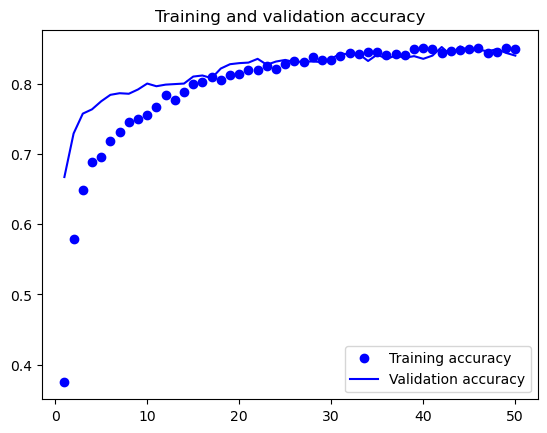

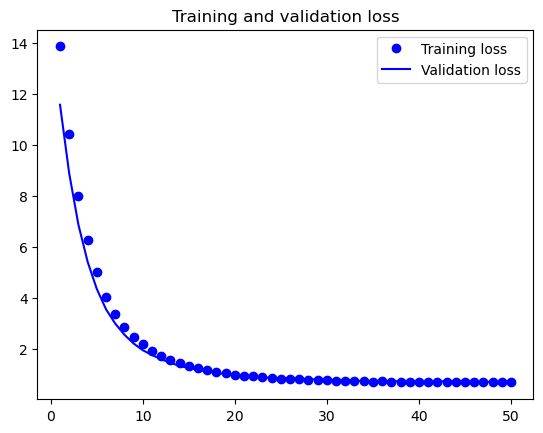

In [36]:
# Plot results
import matplotlib.pyplot as plt
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
import keras
# Check a photo to classify
img_path = 'trash_classifier/test/Plastic/Plastic_1214.jpg'
img = keras.utils.load_img(
    str(curr_dir / img_path),
    target_size=(224, 224)
)
img_array = keras.utils.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array = keras.applications.vgg16.preprocess_input(img_array)

features = base_model.predict(img_array)


# Get the predicted class
predictions = model_vgg16.predict(features)

predicted_class = np.argmax(predictions[0])

# Print the predicted class
predicted_class_name = CATEGORIES[predicted_class]
print(f"Predicted class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Predicted class: Glass


In [ ]:
import keras


base_model: keras.applications.VGG16 = keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)


# 1. Data augmentation constant
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.1),
  keras.layers.RandomZoom(0.1),
])

# 2. Freeze the base model to fine-tune only the top layers
base_model.trainable = False  # Freeze convolutional base

# 3. Create the model
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(9, activation='softmax')(x)
model_vgg16 = keras.Model(inputs, outputs)

model_vgg16.summary()
# 4. Compile the model
model_vgg16.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
  metrics=['accuracy']
)

# 5. Create callback to save the best model
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath=curr_dir / 'trash_classifier' / 'vgg16.keras',
    save_best_only=True,
    monitor='val_loss',
  )
]

# 6. Train the model
history_vgg16 = model_vgg16.fit(
  train_dataset,
  epochs=10,
  validation_data=validation_dataset,
  callbacks=callbacks,
)

# 7. Evaluate the model
loss, accuracy = model_vgg16.evaluate(test_dataset)
print(f"Test accuracy: {accuracy:.2f}")


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_46[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_112 (Dense)   │ (None, 256)       │  6,422,784 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_61          │ (None, 256)       │          0 │ dense_112[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_113 (Dense)   │ (None, 9)         │      2,313 │ dropout_61[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,139,785 (80.64 MB)

 Trainable params: 6,425,097 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
  1/282 ━━━━━━━━━━━━━━━━━━━━ 38:54 8s/step - accuracy: 0.1875 - loss: 15.6787

KeyboardInterrupt: 